In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import tensorflow as tf 

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
cd C:\Users\ASUS\Desktop\dataset-460-40

C:\Users\ASUS\Desktop\dataset-460-40


In [5]:
import os
import json
from glob import glob
import numpy as np
from numpy import array
from numpy import argmax
from numpy import newaxis
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Concatenate, Activation, Dense

In [6]:
# from google.colab import drive
# drive.mount('/gdrive')

In [7]:
tf.random.set_seed(123)

### Data Preprocessing

In [8]:
def get_compiled_data(path):
    f_path = path
    f_list = sorted(glob(os.path.join(f_path, "*.json")))

    f_compile =[]

    for j in f_list: 
        file = open(j, "r")
        content = file.read()
        data = json.loads(content)
        f_compile.append(data)
    return f_compile

In [9]:
X = get_compiled_data("C:/Users/ASUS/Desktop/system_code/dataset-460-40/x")
y = get_compiled_data("C:/Users/ASUS/Desktop/system_code/dataset-460-40/y")
# X = get_compiled_data("/gdrive/MyDrive/dataset-460-40/x/")
# y = get_compiled_data("/gdrive/MyDrive/dataset-460-40/y/")

In [10]:
#Find min and max values of coordinates
coord_values = []
for i in range(len(X)):
  data = X[i] 
  for j in range(len(data)):
    data1 = data[j]
    for k in range(len(data1)):
      coord_values.append(data1[k])
print(min(coord_values))
print(max(coord_values))

0
499


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=1)

In [12]:
print(len(X_train), len(y_train)) 

414 414


Data Augmentation for X_train and y_train

In [13]:
# ##Data Augmentation (reverse seq)
# for i in range(len(X_train)):
#   compiled_x_reverse = X_train[i][::-1]
#   X_train.append(compiled_x_reverse)

# for i in range(len(y_train)):
#   compiled_y_reverse = y_train[i][::-1]
#   y_train.append(compiled_y_reverse)

In [14]:
# print(len(X_train))
# len(y_train)

In [15]:
# #Data Augmentation (translation by 5 units up and right)
# X_train_trans_aug_1 = [[[v+1 for v in inner1] for inner1 in inner] for inner in X_train]
# X_train_trans_aug_2 = [[[v+3 for v in inner1] for inner1 in inner] for inner in X_train]
# X_train_trans_aug_3 = [[[v+5 for v in inner1] for inner1 in inner] for inner in X_train]
# X_train_trans_aug_4 = [[[v+7 for v in inner1] for inner1 in inner] for inner in X_train]

In [16]:
# import copy
# y_train_trans_aug = copy.deepcopy(y_train)

In [17]:
# X_train.extend(X_train_trans_aug_1)
# y_train.extend(y_train_trans_aug)

# X_train.extend(X_train_trans_aug_2)
# y_train.extend(y_train_trans_aug)

# X_train.extend(X_train_trans_aug_3)
# y_train.extend(y_train_trans_aug)

# X_train.extend(X_train_trans_aug_4)
# y_train.extend(y_train_trans_aug)

In [18]:
# print(len(X_train), len(y_train)) 

Remove sequences with values above 499

In [19]:
compiled_x = []
compiled_y = []

for i, seq in enumerate(X_train):
  value_check=[]
  for _, coord in enumerate(seq):
    coord_01 = coord[0]
    coord_02 = coord[1]
    value_check.append(coord_01)
    value_check.append(coord_02)
  if max(value_check) < 500:
    compiled_x.append(seq)
    compiled_y.append(y_train[i])
    

In [20]:
print(len(compiled_x), len(compiled_y), len(X_valid), len(y_valid))

414 414 46 46


In [21]:
#For variable naming standardisation, "rename" X_valid to compiled_x_valid
compiled_x_valid = X_valid
compiled_y_valid = y_valid

### For encoder input (training)

In [22]:
encoder_input = []
for i in range(len(compiled_x)):
  data = compiled_x[i]   
  while len(data) < 267:                        #The sequence length of the longest input sample was earlier found to be 267 (not shown in this colab)
    data.append([500,500])                      #Make all samples to be of the same sequence length by padding it with 500. 
  encoder_input.append(data)

In [23]:
encoder_input = np.array(encoder_input)
encoder_input.shape

(414, 267, 2)

One-hot encode encoder input (training)


In [24]:
# Concatenate all coordinates side by side so that [(12,15),(23, 30),(32, 41),...] becomes [12,15,23,30,32,41,...]
X1 = list()
for i in range(encoder_input.shape[0]):
  row=list()
  for j in range(267):                          #267 because there are 267 time-step in each sequence
    row.append(encoder_input[i][j][0])
    row.append(encoder_input[i][j][1])
  X1.append(row)

In [25]:
X1 = np.array(X1)
X1.shape

(414, 534)

In [26]:
X1 = to_categorical([X1], num_classes=501)      #501 cuz 0-499 for input values, 500 for padding
X1.shape

(1, 414, 534, 501)

In [27]:
X1 = X1.reshape(414, 534, 501)
X1.shape

(414, 534, 501)

###For encoder input (validation)

In [28]:
encoder_input_valid = []
for i in range(len(compiled_x_valid)):
  data = compiled_x_valid[i]   
  while len(data) < 267:                        #The sequence length of the longest input sample was earlier found to be 267 (not shown in this colab)
    data.append([500,500])                      #Make all samples to be of the same sequence length by padding it with 500. 
  encoder_input_valid.append(data)

In [29]:
encoder_input_valid = np.array(encoder_input_valid)
encoder_input_valid.shape

(46, 267, 2)

In [30]:
X1_valid = list()
for i in range(encoder_input_valid.shape[0]):
  row=list()
  for j in range(267):                           #267 cuz there are 267 time-step in each sequence
    row.append(encoder_input_valid[i][j][0])
    row.append(encoder_input_valid[i][j][1])
  X1_valid.append(row)

In [31]:
X1_valid = np.array(X1_valid)
X1_valid.shape

(46, 534)

In [32]:
X1_valid = to_categorical([X1_valid], num_classes=501)
X1_valid.shape

(1, 46, 534, 501)

In [33]:
X1_valid = X1_valid.reshape(46, 534, 501)
X1_valid.shape

(46, 534, 501)

###For decoder_target (training)

In [34]:
Y = []
for i in range(len(compiled_y)):
  data = compiled_y[i]                                   
  while len(data) < 267:                         #Make all samples to be of the same sequence length by padding it with "2"
    data.append(2)
  Y.append(data)

In [35]:
Y = np.array(Y)
Y.shape

(414, 267)

In [36]:
Y = to_categorical([Y], num_classes=4)
Y.shape

(1, 414, 267, 4)

In [37]:
Y = Y.reshape(414, 267, 4)
Y.shape

(414, 267, 4)

###For decoder_target (validation)

In [38]:
Y_valid = []
for i in range(len(compiled_y_valid)):
  data = compiled_y_valid[i]                                   
  while len(data) < 267:                        #Make all samples to be of the same sequence length by padding it with "2"
    data.append(2)
  Y_valid.append(data)

In [39]:
Y_valid = np.array(Y_valid)
Y_valid.shape

(46, 267)

In [40]:
Y_valid = to_categorical([Y_valid], num_classes=4)
Y_valid.shape

(1, 46, 267, 4)

In [41]:
Y_valid = Y_valid.reshape(46, 267, 4)
Y_valid.shape

(46, 267, 4)

###For decoder input (shifted version of decoder target) - (training)

In [42]:
X2 = []
for i in range(len(compiled_y)):
  data = compiled_y[i] 
  while len(data) < 267:                         #Make all samples to be of the same sequence length by padding it with two
    data.append(2)
  data = [3] + data[:-1]                         #3 for indicating start of decoder input sequence (requirement for force teaching)
  X2.append(data)

In [43]:
X2 = np.array(X2)
X2.shape

(414, 267)

In [44]:
X2 = to_categorical([X2], num_classes=4)
X2.shape

(1, 414, 267, 4)

In [45]:
X2 = X2.reshape(414, 267, 4)
X2.shape

(414, 267, 4)

### For decoder input (shifted version of decoder target) - (validation)

In [46]:
X2_valid = []
for i in range(len(compiled_y_valid)):
  data = compiled_y_valid[i] 
  while len(data) < 267:                        #Make all samples to be of the same sequence length by padding it with two
    data.append(2)
  data = [3] + data[:-1]                        #3 for indicating start of decoder input sequence (requirement for force teaching)
  X2_valid.append(data)

In [47]:
X2_valid = np.array(X2_valid)
X2_valid.shape

(46, 267)

In [48]:
X2_valid = to_categorical([X2_valid], num_classes=4)
X2_valid.shape

(1, 46, 267, 4)

In [49]:
X2_valid = X2_valid.reshape(46, 267, 4)
X2_valid.shape

(46, 267, 4)

###Creation of test samples

In [50]:
compiled_data = get_compiled_data("C:/Users/ASUS/Desktop/system_code/dataset-460-40/x_test")
#compiled_data = get_compiled_data("/gdrive/MyDrive/dataset-460-40/x_test/")

In [51]:
encoder_input_test = []
for i in range(len(compiled_data)):
  data = compiled_data[i]   
  while len(data) < 267:                         #The sequence length of the longest input sample was earlier found to be 267 (not shown in this colab)
    data.append([500,500])                       #Make all samples to be of the same sequence length by padding it with 500. 
  encoder_input_test.append(data)

In [52]:
encoder_input_test = np.array(encoder_input_test)
encoder_input_test.shape

(40, 267, 2)

In [53]:
X1_test = list()
for i in range(encoder_input_test.shape[0]):
  row=list()
  for j in range(267):                           #267 cuz there are 267 time-step in each sequence
    row.append(encoder_input_test[i][j][0])
    row.append(encoder_input_test[i][j][1])
  X1_test.append(row)

In [54]:
X1_test = np.array(X1_test)
X1_test.shape

(40, 534)

In [55]:
X1_test = to_categorical([X1_test], num_classes=501)
X1_test.shape

(1, 40, 534, 501)

In [56]:
X1_test = X1_test.reshape(40, 534, 501)
X1_test.shape

(40, 534, 501)

In [57]:
compiled_data = get_compiled_data("C:/Users/ASUS/Desktop/system_code/dataset-460-40/y_test")
#compiled_data = get_compiled_data("/gdrive/MyDrive/dataset-460-40/y_test/")


In [58]:
Y_test = []
for i in range(len(compiled_data)):
  data = compiled_data[i]                                   
  while len(data) < 267:                          #Make all samples to be of the same sequence length by padding it with "2"
    data.append(2)
  Y_test.append(data)

In [59]:
Y_test = np.array(Y_test)
Y_test.shape

(40, 267)

In [60]:
Y_test = to_categorical([Y_test], num_classes=4)
Y_test.shape

(1, 40, 267, 4)

In [61]:
Y_test = Y_test.reshape(40, 267, 4)
Y_test.shape

(40, 267, 4)

# Model creation

In [62]:
num_encoder_tokens = 501
num_decoder_tokens = 4
latent_dim = 128

encoder_inputs = Input(shape=(None, num_encoder_tokens))
decoder_inputs = Input(shape=(None, num_decoder_tokens))

encoder_outputs_1, h1, c1 = LSTM(latent_dim, return_state=True, return_sequences=True)(encoder_inputs) 
encoder_outputs_2, h2, c2 = LSTM(latent_dim, return_state=True)(encoder_outputs_1) 
encoder_states = [h1, c1, h2, c2]

out_layer1 = LSTM(latent_dim, return_sequences=True, return_state=True)
out_layer2 = LSTM(latent_dim, return_sequences=True, return_state=True)

decoder_outputs_1, dh1, dc1 = out_layer1(decoder_inputs,initial_state= [h1, c1])
decoder_outputs_2, dh2, dc2 = out_layer2(decoder_outputs_1, initial_state= [h2, c2])
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs_2)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 501)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, None, 128),  322560      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  68096       input_2[0][0]                    
                                                                 lstm[0][1]                   

In [63]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input_h1 = Input(shape=(latent_dim,))
decoder_state_input_c1 = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c, decoder_state_input_h1, decoder_state_input_c1]
						 
decoder_output, h, c = out_layer1(decoder_inputs, initial_state=decoder_states_inputs[:2])
decoder_output_1, h1, c1 = out_layer2(decoder_output, initial_state=decoder_states_inputs[-2:])

decoder_states = [h, c, h1, c1]
decoder_outputs = decoder_dense(decoder_output_1)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs] + decoder_states)

decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  68096       input_2[0][0]                    
                                                                 input_3[0][0]              

In [64]:
# #Bidirectional

# # returns train, inference_encoder and inference_decoder models
# def define_models(n_features_input, n_features_output, n_units):

# 	# define training encoder
# 	encoder_inputs = Input(shape=(None, n_features_input))
# 	encoder = Bidirectional(LSTM(n_units, return_state=True))                     
# 	encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
# 	state_h = Concatenate()([forward_h, backward_h])
# 	state_c = Concatenate()([forward_c, backward_c])
# 	encoder_states = [state_h, state_c]

# 	# define training decoder
# 	decoder_inputs = Input(shape=(None, n_features_output))
# 	decoder_lstm = LSTM(n_units*2, return_sequences=True, return_state=True)      #Multiple by 2 cuz of bidirectional
# 	decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# 	decoder_dense = Dense(n_features_output, activation='softmax')
# 	decoder_outputs = decoder_dense(decoder_outputs)
# 	model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
 
# 	# define inference encoder
# 	encoder_model = Model(encoder_inputs, encoder_states)
 
# 	# define inference decoder
# 	decoder_state_input_h = Input(shape=(n_units*2,))                             #Multiple by 2 cuz of bidirectional
# 	decoder_state_input_c = Input(shape=(n_units*2,))                             #Multiple by 2 cuz of bidirectional
# 	decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# 	decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
# 	decoder_states = [state_h, state_c]
# 	decoder_outputs = decoder_dense(decoder_outputs)
# 	decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
 
# 	# return all models
# 	return model, encoder_model, decoder_model

### Metrics

In [65]:
precision =tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [66]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())    
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [67]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0, nesterov=False)

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_f1", mode='max', patience = 15, restore_best_weights=True)

model.compile(loss=loss, optimizer=optimizer, metrics=['acc', precision, recall, f1])

# generate training dataset
print(X1.shape,X2.shape,Y.shape)
# train model
#history = model.fit([X1, X2], Y, batch_size=32, epochs=200)
history = model.fit([X1, X2], Y, batch_size=32, epochs=200, validation_data=([X1_valid, X2_valid],Y_valid),callbacks=[early_stop])

(414, 534, 501) (414, 267, 4) (414, 267, 4)
Epoch 1/200
13/13 [==============================] - 8s 278ms/step - loss: 1.1595 - acc: 0.7470 - precision: 1.0000 - recall: 0.0811 - f1: 0.0268 - val_loss: 0.7548 - val_acc: 0.8377 - val_precision: 1.0000 - val_recall: 0.6225 - val_f1: 0.1881
Epoch 2/200
13/13 [==============================] - 2s 193ms/step - loss: 0.5298 - acc: 0.8118 - precision: 0.9913 - recall: 0.6283 - f1: 0.2058 - val_loss: 0.3810 - val_acc: 0.8381 - val_precision: 0.9789 - val_recall: 0.6622 - val_f1: 0.2031
Epoch 3/200
13/13 [==============================] - 2s 193ms/step - loss: 0.3648 - acc: 0.8259 - precision: 0.8935 - recall: 0.7453 - f1: 0.2736 - val_loss: 0.3117 - val_acc: 0.8359 - val_precision: 0.8448 - val_recall: 0.8302 - val_f1: 0.2896
Epoch 4/200
13/13 [==============================] - 2s 191ms/step - loss: 0.3138 - acc: 0.8409 - precision: 0.8825 - recall: 0.7892 - f1: 0.2995 - val_loss: 0.2846 - val_acc: 0.8514 - val_precision: 0.9010 - val_recall: 

13/13 [==============================] - 3s 199ms/step - loss: 0.2522 - acc: 0.8652 - precision: 0.8716 - recall: 0.8564 - f1: 0.3730 - val_loss: 0.2404 - val_acc: 0.8691 - val_precision: 0.8731 - val_recall: 0.8648 - val_f1: 0.3452
Epoch 35/200
13/13 [==============================] - 3s 203ms/step - loss: 0.2503 - acc: 0.8653 - precision: 0.8697 - recall: 0.8600 - f1: 0.3796 - val_loss: 0.2382 - val_acc: 0.8685 - val_precision: 0.8744 - val_recall: 0.8624 - val_f1: 0.3426
Epoch 36/200
13/13 [==============================] - 3s 203ms/step - loss: 0.2490 - acc: 0.8654 - precision: 0.8712 - recall: 0.8594 - f1: 0.3810 - val_loss: 0.2374 - val_acc: 0.8688 - val_precision: 0.8732 - val_recall: 0.8652 - val_f1: 0.3397
Epoch 37/200
13/13 [==============================] - 3s 201ms/step - loss: 0.2480 - acc: 0.8661 - precision: 0.8709 - recall: 0.8613 - f1: 0.3800 - val_loss: 0.2362 - val_acc: 0.8683 - val_precision: 0.8737 - val_recall: 0.8626 - val_f1: 0.3407
Epoch 38/200
13/13 [=========

13/13 [==============================] - 3s 201ms/step - loss: 0.2404 - acc: 0.8689 - precision: 0.8714 - recall: 0.8657 - f1: 0.3850 - val_loss: 0.2295 - val_acc: 0.8737 - val_precision: 0.8753 - val_recall: 0.8727 - val_f1: 0.3470
Epoch 68/200
13/13 [==============================] - 3s 201ms/step - loss: 0.2396 - acc: 0.8697 - precision: 0.8719 - recall: 0.8668 - f1: 0.3851 - val_loss: 0.2278 - val_acc: 0.8744 - val_precision: 0.8769 - val_recall: 0.8720 - val_f1: 0.3482
Epoch 69/200
13/13 [==============================] - 3s 204ms/step - loss: 0.2395 - acc: 0.8696 - precision: 0.8717 - recall: 0.8670 - f1: 0.3852 - val_loss: 0.2285 - val_acc: 0.8732 - val_precision: 0.8754 - val_recall: 0.8709 - val_f1: 0.3518
Epoch 70/200
13/13 [==============================] - 3s 200ms/step - loss: 0.2397 - acc: 0.8693 - precision: 0.8717 - recall: 0.8666 - f1: 0.3842 - val_loss: 0.2280 - val_acc: 0.8737 - val_precision: 0.8752 - val_recall: 0.8713 - val_f1: 0.3513
Epoch 71/200
13/13 [=========

13/13 [==============================] - 3s 202ms/step - loss: 0.2371 - acc: 0.8706 - precision: 0.8720 - recall: 0.8690 - f1: 0.3902 - val_loss: 0.2259 - val_acc: 0.8755 - val_precision: 0.8766 - val_recall: 0.8744 - val_f1: 0.3503
Epoch 101/200
13/13 [==============================] - 3s 203ms/step - loss: 0.2368 - acc: 0.8704 - precision: 0.8718 - recall: 0.8687 - f1: 0.3891 - val_loss: 0.2259 - val_acc: 0.8758 - val_precision: 0.8764 - val_recall: 0.8750 - val_f1: 0.3527
Epoch 102/200
13/13 [==============================] - 3s 201ms/step - loss: 0.2371 - acc: 0.8708 - precision: 0.8720 - recall: 0.8691 - f1: 0.3878 - val_loss: 0.2259 - val_acc: 0.8749 - val_precision: 0.8770 - val_recall: 0.8716 - val_f1: 0.3529
Epoch 103/200
13/13 [==============================] - 3s 207ms/step - loss: 0.2370 - acc: 0.8705 - precision: 0.8720 - recall: 0.8684 - f1: 0.3871 - val_loss: 0.2265 - val_acc: 0.8746 - val_precision: 0.8751 - val_recall: 0.8741 - val_f1: 0.3471
Epoch 104/200
13/13 [=====

In [68]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 501)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, None, 128),  322560      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  68096       input_2[0][0]                    
                                                                 lstm[0][1]                   

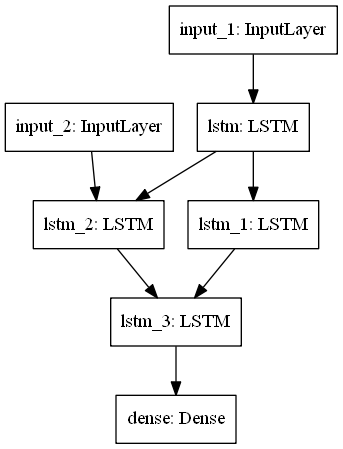

In [69]:
from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(model,to_file='model.png')
#tf.keras.utils.plot_model(model,to_file='/content/model.png')

dict_keys(['loss', 'acc', 'precision', 'recall', 'f1', 'val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_f1'])


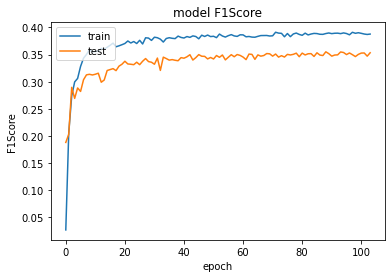

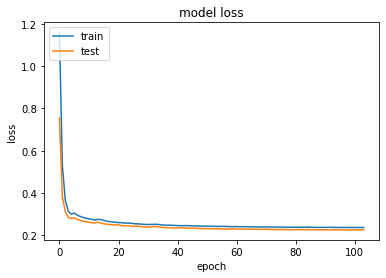

In [70]:
import matplotlib.pyplot as plt 
print(history.history.keys())
# summarize history for F1Score
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model F1Score')
plt.ylabel('F1Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [71]:
def predict_sequence(encoder_model, decoder_model, input, n_steps_out, n_features): 

	state = encoder_model.predict(input)
	# start of sequence input
	target_seq = array([0.0 for _ in range(n_features)]).reshape(1, 1, n_features)

	# collect predictions
	output = list()
	for t in range(n_steps_out):
		# predict next char
		output_tokens, h, c, h1, c1 = decoder_model.predict([target_seq] + state)
		# store prediction
		output.append(output_tokens[0,0,:])
		# update state
		state = [h, c, h1, c1]
		# update target sequence
		target_seq = output_tokens
	return array(output)

def one_hot_decode(encoded_seq):
 	return [argmax(vector) for vector in encoded_seq]

#Evaluate with test data

In [77]:
prediction= []
n_features=4
n_steps_out = 267
for i in range(X1_test.shape[0]):
  test = X1_test[i]
  test = test[newaxis,:, :]
  pred = predict_sequence(encoder_model, decoder_model, test, n_steps_out, n_features)
  pred = one_hot_decode(pred)
  prediction.extend(pred)

In [78]:
compiled_data = get_compiled_data("C:/Users/ASUS/Desktop/system_code/dataset-460-40/y_test")
#compiled_data = get_compiled_data("/gdrive/MyDrive/dataset-460-40/y_test/")

In [79]:
truth = []
for i in range(len(compiled_data)):
  data = compiled_data[i]                                   
  while len(data) < 267:                          
    data.append(2)
  truth.extend(data)

In [80]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [81]:
matrix = confusion_matrix(truth, prediction, labels=[0,1,2])
print('Confusion matrix : \n',matrix)
print(classification_report(truth, prediction, labels=[0,1,2]))

Confusion matrix : 
 [[  15 1415  221]
 [  24 1866  263]
 [   0  920 5956]]
              precision    recall  f1-score   support

           0       0.38      0.01      0.02      1651
           1       0.44      0.87      0.59      2153
           2       0.92      0.87      0.89      6876

    accuracy                           0.73     10680
   macro avg       0.58      0.58      0.50     10680
weighted avg       0.74      0.73      0.70     10680



###Examine single test sample

In [82]:
test = X1_test[0]
test.shape
test = test[newaxis,:, :]
test.shape

(1, 534, 501)

In [83]:
n_features=4
n_steps_out = 267
prediction = predict_sequence(encoder_model, decoder_model, test, n_steps_out, n_features)
prediction = one_hot_decode(prediction)
prediction = np.array(prediction)

In [84]:
truth = Y_test[0]
truth = one_hot_decode(truth)
truth = np.array(truth)

In [85]:
matrix = confusion_matrix(truth, prediction, labels=[0,1,2])
print('Confusion matrix : \n',matrix)
print(classification_report(truth, prediction, labels=[0,1,2]))

Confusion matrix : 
 [[ 1 57 35]
 [ 0 48 29]
 [ 0  0 97]]
              precision    recall  f1-score   support

           0       1.00      0.01      0.02        93
           1       0.46      0.62      0.53        77
           2       0.60      1.00      0.75        97

    accuracy                           0.55       267
   macro avg       0.69      0.54      0.43       267
weighted avg       0.70      0.55      0.43       267



In [86]:
prediction

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2], dtype=int64)

In [87]:
truth

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2], dtype=int64)

### Examine training data (optional)

In [ ]:
test = X1[0]
test.shape
test = test[newaxis,:, :]
test.shape

In [ ]:
n_features=4
n_steps_out = 267
prediction = predict_sequence(encoder_model, decoder_model, test, n_steps_out, n_features)
prediction = one_hot_decode(prediction)
prediction = np.array(prediction)

In [ ]:
truth = Y[0]
truth = one_hot_decode(truth)
truth = np.array(truth)

In [ ]:
prediction

In [ ]:
truth